![Header.jpeg](../assets/banner_linreg.png)

# Analisis dan Prediksi Konsumsi Energi pada Bangunan Menggunakan Algoritma *Lasso Regression*

---

<h2>Daftar isi</h2>

- <a href=#bu>Business Understanding</a>
- <a href=#du>Data Understanding</a>
- <a href=#dp>Data Preparation</a>
- <a href=#ml>Modeling</a>
- <a href=#ev>Evaluation</a>
- <a href=#dy>Deployment</a>


<hr>


*<h2 id='bu'>Business Understanding</h2>*

Hands-On ini menggunakan algoritma Lasso Regression yang termasuk ke dalam regresi teregularisasi untuk memprediksi konsumsi energi pada bangunan dengan karakteristik tertentu. 

#### Data Source:
https://www.kaggle.com/datasets/govindaramsriram/energy-consumption-dataset-linear-regression

<hr>

*<h2 id='du'>Data Understanding</h2>*

#### Impor Library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import joblib

#### Impor Data

In [2]:
df = pd.read_csv("../data/train_energy_data.csv")

In [3]:
df.head()

,Building Type,Square Footage,Number of Occupants,Appliances Used,Average Temperature,Day of Week,Energy Consumption
0,Residential,7063,76,10,29.84,Weekday,2713.95
1,Commercial,44372,66,45,16.72,Weekday,5744.99
2,Industrial,19255,37,17,14.30,Weekend,4101.24
3,Residential,13265,14,41,32.82,Weekday,3009.14
4,Commercial,13375,26,18,11.92,Weekday,3279.17


#### Informasi Kolom

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Building Type        1000 non-null   object 
 1   Square Footage       1000 non-null   int64  
 2   Number of Occupants  1000 non-null   int64  
 3   Appliances Used      1000 non-null   int64  
 4   Average Temperature  1000 non-null   float64
 5   Day of Week          1000 non-null   object 
 6   Energy Consumption   1000 non-null   float64
dtypes: float64(2), int64(3), object(2)
memory usage: 54.8+ KB


- Building Type: Fitur kategoris yang mewakili tipe bangunan.

- Square Footage: Fitur numerik yang mewakili total luas persegi bangunan.

- Number of Occupants: Fitur numerik yang menunjukkan jumlah orang yang menempati bangunan.

- Appliances Used: Fitur numerik yang mewakili jumlah peralatan yang digunakan di dalam bangunan.

- Average Temperature: Fitur numerik yang mewakili suhu rata-rata bangunan atau area iklim (dalam Celsius).

- Day of Week t: Fitur kategoris yang mewakili apakah titik data sesuai dengan hari kerja atau akhir pekan.

- Energy Consumption: Variabel target numerik yang mewakili konsumsi energi bangunan dalam kWh (kilowatt-jam). Ini adalah nilainya

#### Statistik Deskriptif

In [5]:
df.describe(include="all")

,Building Type,Square Footage,Number of Occupants,Appliances Used,Average Temperature,Day of Week,Energy Consumption
count,1000,1000.000,1000.000000,1000.000000,1000.000000,1000,1000.000000
unique,3,NaN,NaN,NaN,NaN,2,NaN
top,Residential,NaN,NaN,NaN,NaN,Weekday,NaN
freq,347,NaN,NaN,NaN,NaN,507,NaN
mean,NaN,25462.388,48.372000,25.606000,22.611390,NaN,4166.252570
std,NaN,14294.554,29.061972,14.105166,7.139943,NaN,933.313064
min,NaN,560.000,1.000000,1.000000,10.050000,NaN,1683.950000
25%,NaN,13169.750,22.000000,13.000000,16.475000,NaN,3509.482500
50%,NaN,25477.000,47.000000,26.000000,22.815000,NaN,4175.730000
75%,NaN,37446.250,73.250000,38.000000,28.850000,NaN,4863.850000


In [6]:
def dist_obj_cols(feature: str):
    ax = sns.histplot(x=df[feature])

    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + (p.get_width() / 2), p.get_height()), 
                    ha='center', va='bottom', fontsize=12)
    plt.show()

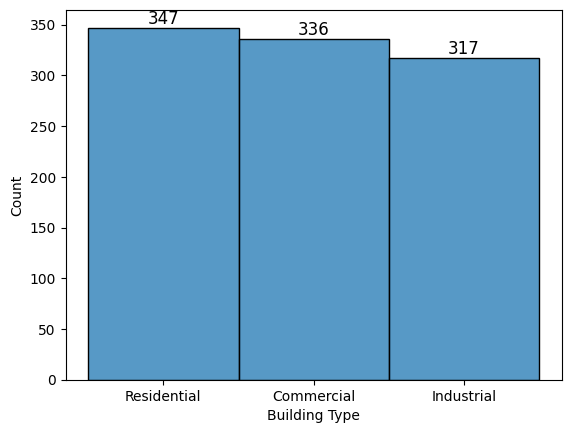

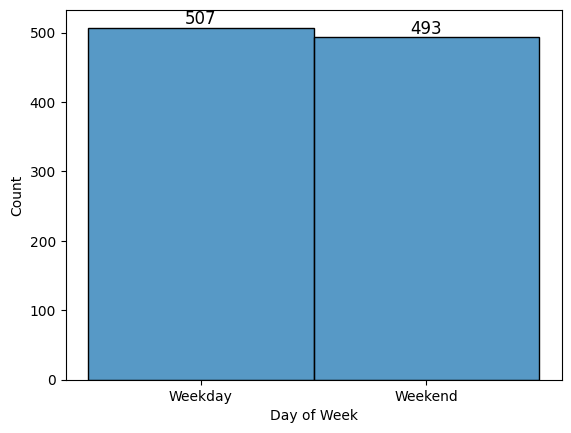

In [7]:
for x in df.columns:
    if df[x].dtype == "object":
        dist_obj_cols(x)

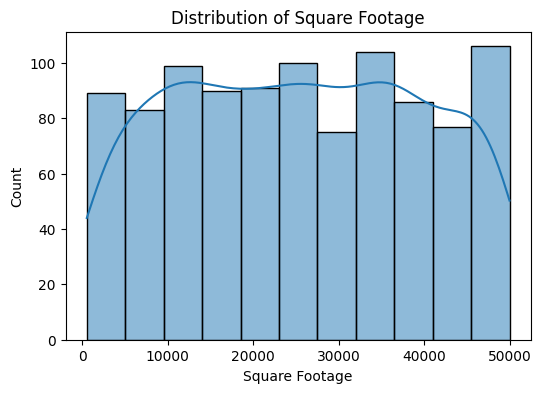

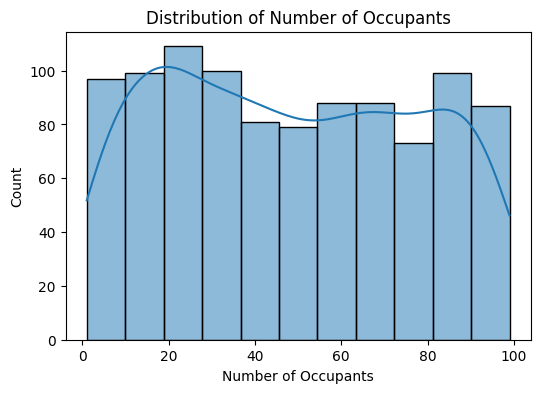

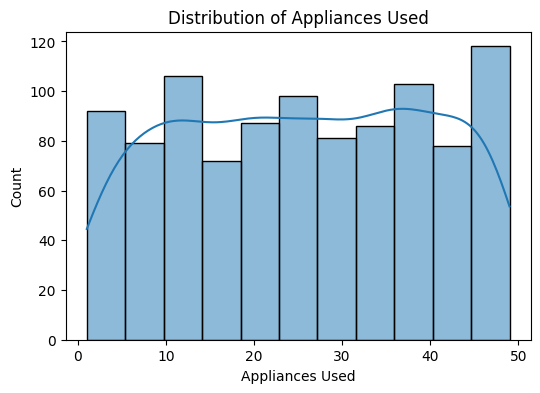

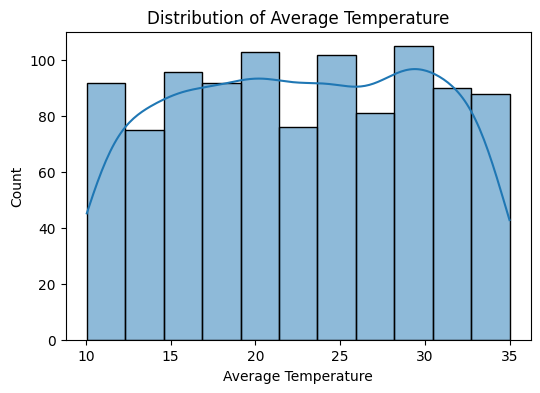

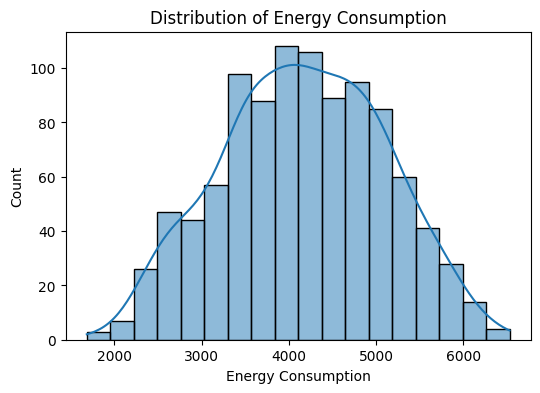

In [8]:
for x in df.select_dtypes(include=['number']).columns:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[x], kde=True)
    plt.title(f'Distribution of {x}')
    
plt.show()

<hr>

*<h2 id='du'>Data Preparation</h2>*

#### Cek Data Null

In [9]:
df.isna().sum()

Building Type          0
Square Footage         0
Number of Occupants    0
Appliances Used        0
Average Temperature    0
Day of Week            0
Energy Consumption     0
dtype: int64

#### Cek Data Duplikat

In [10]:
df.duplicated().sum()

0

#### Cek Outlier

In [11]:
df_check_outlier = df.select_dtypes(exclude=["object"])

In [12]:
q1 = df_check_outlier.quantile(0.25)
q3 = df_check_outlier.quantile(0.75)
iqr = q3 - q1
low_bound = q1 - (1.5 * iqr)
up_bound = q3 + (1.5 * iqr)

outliers = ((df_check_outlier < low_bound) | (df_check_outlier > up_bound))
outliers.sum()

Square Footage         0
Number of Occupants    0
Appliances Used        0
Average Temperature    0
Energy Consumption     0
dtype: int64

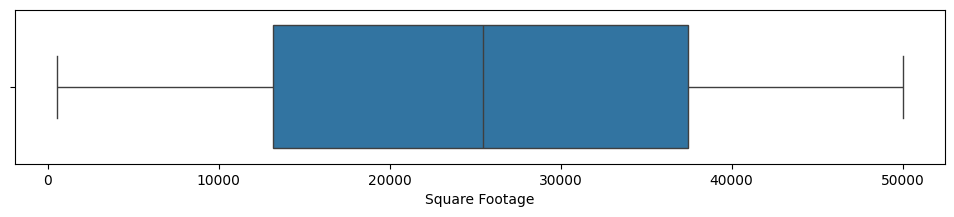

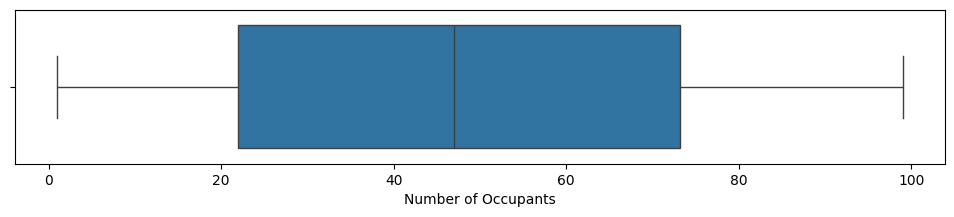

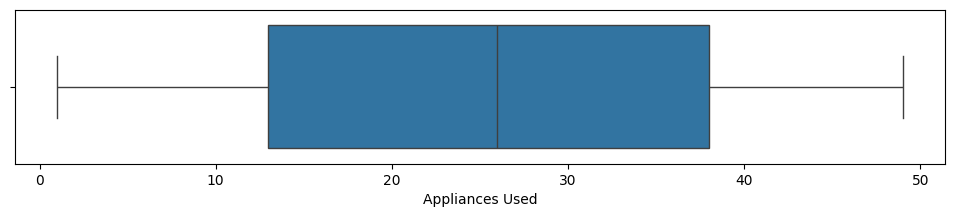

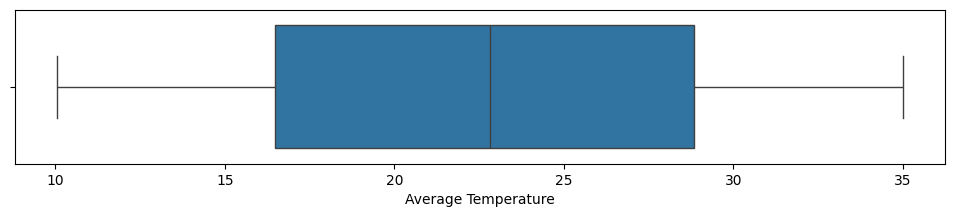

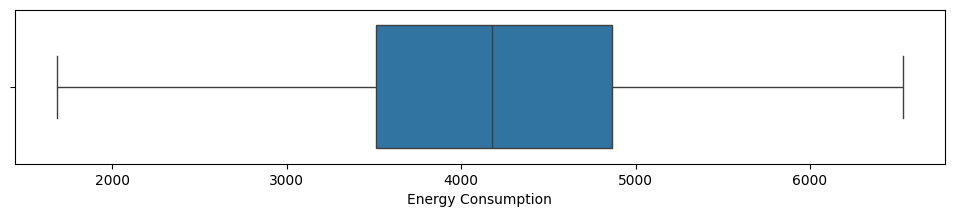

In [13]:
for x in df_check_outlier:
    plt.figure(figsize=(12, 2))
    sns.boxplot(data=df_check_outlier, x=x)

plt.show()

#### Encoding

In [14]:
df.select_dtypes(include=["object"]).columns

Index(['Building Type', 'Day of Week'], dtype='object')

In [15]:
df_encoded = pd.get_dummies(
    data=df,
    columns=df.select_dtypes(include=["object"]).columns
)

df_encoded.tail()

,Square Footage,Number of Occupants,Appliances Used,Average Temperature,Energy Consumption,Building Type_Commercial,Building Type_Industrial,Building Type_Residential,Day of Week_Weekday,Day of Week_Weekend
995,14419,68,44,23.95,3661.21,False,False,True,False,True
996,12194,7,22,14.67,3546.34,False,True,False,False,True
997,39562,88,20,32.18,5147.21,True,False,False,True,False
998,8348,67,37,16.48,3244.98,False,False,True,False,True
999,15813,57,11,31.40,3423.63,True,False,False,False,True


In [16]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Square Footage             1000 non-null   int64  
 1   Number of Occupants        1000 non-null   int64  
 2   Appliances Used            1000 non-null   int64  
 3   Average Temperature        1000 non-null   float64
 4   Energy Consumption         1000 non-null   float64
 5   Building Type_Commercial   1000 non-null   bool   
 6   Building Type_Industrial   1000 non-null   bool   
 7   Building Type_Residential  1000 non-null   bool   
 8   Day of Week_Weekday        1000 non-null   bool   
 9   Day of Week_Weekend        1000 non-null   bool   
dtypes: bool(5), float64(2), int64(3)
memory usage: 44.1 KB


In [17]:
new_df = df_encoded.astype("float64")

In [18]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Square Footage             1000 non-null   float64
 1   Number of Occupants        1000 non-null   float64
 2   Appliances Used            1000 non-null   float64
 3   Average Temperature        1000 non-null   float64
 4   Energy Consumption         1000 non-null   float64
 5   Building Type_Commercial   1000 non-null   float64
 6   Building Type_Industrial   1000 non-null   float64
 7   Building Type_Residential  1000 non-null   float64
 8   Day of Week_Weekday        1000 non-null   float64
 9   Day of Week_Weekend        1000 non-null   float64
dtypes: float64(10)
memory usage: 78.3 KB


In [19]:
new_df.head()

,Square Footage,Number of Occupants,Appliances Used,Average Temperature,Energy Consumption,Building Type_Commercial,Building Type_Industrial,Building Type_Residential,Day of Week_Weekday,Day of Week_Weekend
0,7063.0,76.0,10.0,29.84,2713.95,0.0,0.0,1.0,1.0,0.0
1,44372.0,66.0,45.0,16.72,5744.99,1.0,0.0,0.0,1.0,0.0
2,19255.0,37.0,17.0,14.30,4101.24,0.0,1.0,0.0,0.0,1.0
3,13265.0,14.0,41.0,32.82,3009.14,0.0,0.0,1.0,1.0,0.0
4,13375.0,26.0,18.0,11.92,3279.17,1.0,0.0,0.0,1.0,0.0


#### Cek Korelasi

<Axes: >

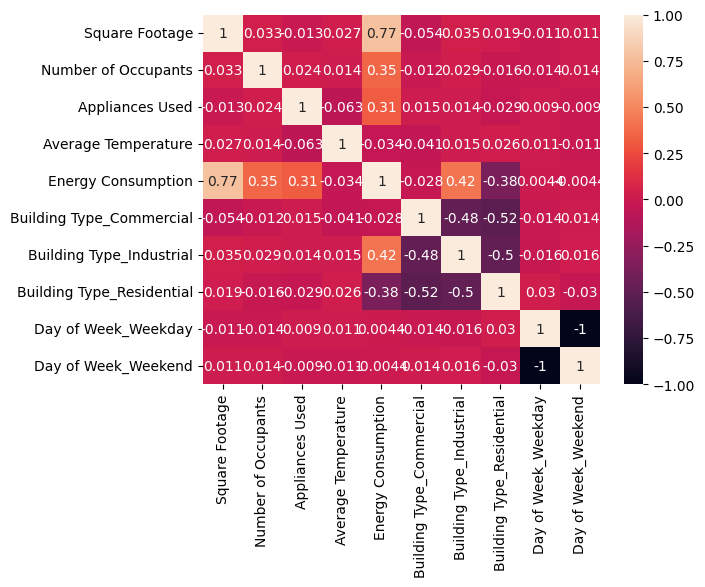

In [20]:
sns.heatmap(new_df.corr(), annot=True)

#### Splitting Data

In [21]:
X = new_df.drop(columns="Energy Consumption")
y = new_df["Energy Consumption"]

In [22]:
X

,Square Footage,Number of Occupants,Appliances Used,Average Temperature,Building Type_Commercial,Building Type_Industrial,Building Type_Residential,Day of Week_Weekday,Day of Week_Weekend
0,7063.0,76.0,10.0,29.84,0.0,0.0,1.0,1.0,0.0
1,44372.0,66.0,45.0,16.72,1.0,0.0,0.0,1.0,0.0
2,19255.0,37.0,17.0,14.30,0.0,1.0,0.0,0.0,1.0
3,13265.0,14.0,41.0,32.82,0.0,0.0,1.0,1.0,0.0
4,13375.0,26.0,18.0,11.92,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...
995,14419.0,68.0,44.0,23.95,0.0,0.0,1.0,0.0,1.0
996,12194.0,7.0,22.0,14.67,0.0,1.0,0.0,0.0,1.0
997,39562.0,88.0,20.0,32.18,1.0,0.0,0.0,1.0,0.0
998,8348.0,67.0,37.0,16.48,0.0,0.0,1.0,0.0,1.0


In [23]:
y

0      2713.95
1      5744.99
2      4101.24
3      3009.14
4      3279.17
        ...   
995    3661.21
996    3546.34
997    5147.21
998    3244.98
999    3423.63
Name: Energy Consumption, Length: 1000, dtype: float64

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
X_train.head()

,Square Footage,Number of Occupants,Appliances Used,Average Temperature,Building Type_Commercial,Building Type_Industrial,Building Type_Residential,Day of Week_Weekday,Day of Week_Weekend
29,27072.0,12.0,30.0,32.89,0.0,0.0,1.0,0.0,1.0
535,9874.0,5.0,19.0,20.65,1.0,0.0,0.0,1.0,0.0
695,22427.0,8.0,13.0,26.21,0.0,1.0,0.0,1.0,0.0
557,30129.0,29.0,33.0,23.73,0.0,0.0,1.0,0.0,1.0
836,16350.0,14.0,38.0,18.39,1.0,0.0,0.0,1.0,0.0


In [26]:
X_test.head()

,Square Footage,Number of Occupants,Appliances Used,Average Temperature,Building Type_Commercial,Building Type_Industrial,Building Type_Residential,Day of Week_Weekday,Day of Week_Weekend
521,40192.0,23.0,23.0,30.00,1.0,0.0,0.0,0.0,1.0
737,8406.0,25.0,36.0,19.48,0.0,0.0,1.0,1.0,0.0
740,47719.0,92.0,7.0,32.82,0.0,1.0,0.0,0.0,1.0
660,37435.0,26.0,35.0,21.64,1.0,0.0,0.0,1.0,0.0
411,11331.0,47.0,43.0,21.10,1.0,0.0,0.0,0.0,1.0


#### Skalasi Data

In [27]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [28]:
X_train_scaled

array([[ 0.12018396, -1.21478   ,  0.3210255 , ...,  1.35531525,
        -1.03046381,  1.03046381],
       [-1.07490811, -1.45338153, -0.46676713, ..., -0.73783572,
         0.97043679, -0.97043679],
       [-0.20259792, -1.35112373, -0.89647221, ..., -0.73783572,
         0.97043679, -0.97043679],
       ...,
       [ 0.13866834, -0.36263171,  1.68175823, ..., -0.73783572,
         0.97043679, -0.97043679],
       [ 0.12136529,  0.72811811, -0.03706206, ..., -0.73783572,
         0.97043679, -0.97043679],
       [-1.41568794, -0.90800662, -0.61000216, ..., -0.73783572,
        -1.03046381,  1.03046381]])

In [29]:
X_test_scaled

array([[ 1.03189508, -0.83983475, -0.18029709, ..., -0.73783572,
        -1.03046381,  1.03046381],
       [-1.1769197 , -0.77166289,  0.75073057, ...,  1.35531525,
         0.97043679, -0.97043679],
       [ 1.55494765,  1.51209454, -1.32617728, ..., -0.73783572,
        -1.03046381,  1.03046381],
       ...,
       [-1.51137592,  1.37575082,  1.10881813, ..., -0.73783572,
        -1.03046381,  1.03046381],
       [ 1.07324174, -0.43080357, -1.54102981, ...,  1.35531525,
         0.97043679, -0.97043679],
       [ 0.87123379, -0.4648895 , -1.03970723, ..., -0.73783572,
         0.97043679, -0.97043679]])

<hr>

*<h2 id='ml'>Modeling</h2>*

In [30]:
lasso_cv = LassoCV(alphas=[0.001, 0.01, 0.1, 1, 10], cv=5)
lasso_cv.fit(X_train_scaled, y_train)

print("Best alpha:", lasso_cv.alpha_)

Best alpha: 0.001


In [31]:
lasso_model = Lasso(alpha=0.001)
lasso_model.fit(X_train_scaled, y_train)

Lasso(alpha=0.001)

In [32]:
y_pred = lasso_model.predict(X_test_scaled)

In [33]:
res = pd.DataFrame({"Actual": y_test, "Pred": y_pred})
res.sample(10)

,Actual,Pred
319,5338.17,5338.149098
494,4002.72,4002.703463
318,3707.17,3707.148273
649,3558.78,3558.803363
445,4879.42,4879.398297
280,3446.15,3446.150316
548,4164.50,4164.497405
277,4261.05,4261.047281
55,5505.97,5505.944372
924,3437.74,3437.752574


<hr>

*<h2 id='ml'>Evaluation</h2>*

In [34]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae = mean_absolute_error(y_test, y_pred)
print("MAE:", mae)

print(f"Mean Squared Error: {mse:.4f}")
print(f"R² Score: {r2:.4f}")

MAE: 0.012048971680935666
Mean Squared Error: 0.0002
R² Score: 1.0000


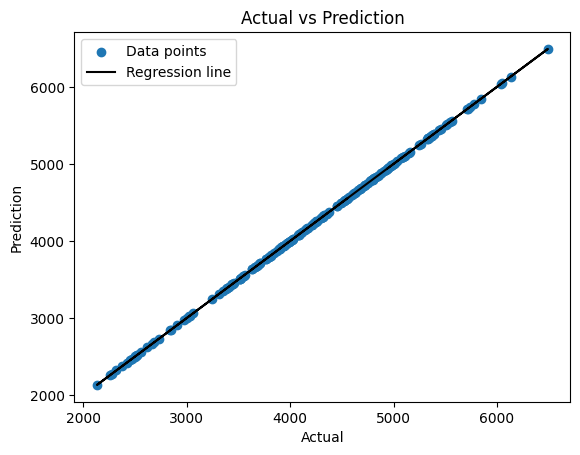

In [35]:
plt.scatter(y_test, y_pred, label='Data points')
m, b = np.polyfit(y_test, y_pred, 1)
plt.plot(y_test, m*y_test + b, color='black', label='Regression line')

plt.xlabel("Actual")
plt.ylabel("Prediction")
plt.title("Actual vs Prediction")
plt.legend()

plt.show()

<hr>

*<h2 id='ml'>Deployment</h2>*

In [36]:
joblib.dump(lasso_model, "../models/model_lasso.joblib")

['../models/model_lasso.joblib']



---


Copyright © 2025 by DGX Development Team, Gunadarma University


https://www.hpc-hub.gunadarma.ac.id/